# Data Simulator

In [4]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal

# Set random seed for reproducibility
np.random.seed(42)

# Function to generate fixed effects F(x)
def generate_fixed_effects(n, d=9, C=None):
    """
    Generate fixed effects F(x) for n samples.
    
    Parameters:
        n (int): Number of samples.
        d (int): Number of predictor variables (default=9).
        C (float): Scaling constant to adjust variance of F(x) to 1.
    
    Returns:
        F (numpy.ndarray): Fixed effect values of shape (n,).
        X (numpy.ndarray): Predictor variables of shape (n, d).
    """
    X = np.random.normal(0, 1, size=(n, d))  # Generate X ~ N(0, I_d)
    # Define F(x) as given in the problem
    Fx = 2 * X[:, 0] + X[:, 1]**2 + 4 * (X[:, 2] > 0) + 2 * np.log(np.abs(X[:, 0] * X[:, 2]))
    
    if C is None:
        # Calculate C such that var(F(x)) = 1
        C = 1 / np.std(Fx)
    
    F = C * Fx
    return F, X

# Function to generate grouped random effects
def generate_grouped_random_effects(n, m, sigma1_squared=1):
    """
    Generate grouped random effects Zb.

    Parameters:
        n (int): Total number of samples.
        m (int): Number of groups.
        sigma1_squared (float): Variance of random effects.

    Returns:
        Zb (numpy.ndarray): Random effects of shape (n,).
        group_ids (numpy.ndarray): Group IDs for each sample.
    """
    group_ids = np.random.choice(m, size=n)  # Assign each sample to a group
    b = np.random.normal(0, np.sqrt(sigma1_squared), size=m)  # Random effects for each group
    Zb = b[group_ids]  # Assign random effects to each sample
    return Zb, group_ids

# Function to generate spatial Gaussian process random effects
def generate_spatial_gp(n, locations, sigma1_squared=1, rho=0.1):
    """
    Generate spatial Gaussian process random effects Zb.

    Parameters:
        n (int): Number of samples.
        locations (numpy.ndarray): Locations of shape (n, 2).
        sigma1_squared (float): Variance of the Gaussian process.
        rho (float): Range parameter for the exponential covariance function.

    Returns:
        Zb (numpy.ndarray): Spatial random effects of shape (n,).
    """
    # Exponential covariance function
    dists = cdist(locations, locations)
    covariance_matrix = sigma1_squared * np.exp(-dists / rho)
    
    # Simulate random effects from multivariate normal distribution
    Zb = multivariate_normal.rvs(mean=np.zeros(n), cov=covariance_matrix)
    return Zb

# Function to generate data based on the mixed effects model
def generate_data(n, model_type="grouped", m=500, sigma1_squared=1, sigma_squared=1, rho=0.1, locations=None):
    """
    Generate data based on the mixed effects model.

    Parameters:
        n (int): Number of samples.
        model_type (str): Type of random effects model ("grouped" or "spatial").
        m (int): Number of groups (only for grouped random effects).
        sigma1_squared (float): Variance of random effects.
        sigma_squared (float): Variance of error term.
        rho (float): Range parameter for spatial GP (only for spatial model).
        locations (numpy.ndarray): Predefined spatial locations (optional, for spatial model).

    Returns:
        y (numpy.ndarray): Response variable of shape (n,).
        X (numpy.ndarray): Predictor variables of shape (n, 9).
        Zb (numpy.ndarray): Random effects of shape (n,).
        epsilon (numpy.ndarray): Error term of shape (n,).
        group_ids or locations (numpy.ndarray): Group IDs or spatial locations.
    """
    # Generate fixed effects
    F, X = generate_fixed_effects(n)
    
    if model_type == "grouped":
        # Generate grouped random effects
        Zb, group_ids = generate_grouped_random_effects(n, m, sigma1_squared)
        locations_or_groups = group_ids
    elif model_type == "spatial":
        if locations is None:
            raise ValueError("For spatial model, locations must be provided.")
        # Generate spatial random effects
        Zb = generate_spatial_gp(n, locations, sigma1_squared, rho)
        locations_or_groups = locations
    else:
        raise ValueError("Invalid model_type. Choose from 'grouped' or 'spatial'.")
    
    # Generate error term
    epsilon = np.random.normal(0, np.sqrt(sigma_squared), size=n)
    
    # Combine to generate response variable y
    y = F + Zb + epsilon
    
    return y, X, Zb, epsilon, locations_or_groups

# Function to generate locations in the specified area
def generate_locations(n, area="train"):
    """
    Generate spatial locations in the specified area.

    Parameters:
        n (int): Number of samples.
        area (str): Area to sample locations from ("train", "interpolation", "extrapolation").

    Returns:
        locations (numpy.ndarray): Locations of shape (n, 2).
    """
    if area == "train" or area == "interpolation":
        # Uniformly sample from [0, 1]^2 excluding [0.5, 1]^2
        locations = []
        while len(locations) < n:
            loc = np.random.uniform(0, 1, size=(n, 2))
            mask = (loc[:, 0] < 0.5) | (loc[:, 1] < 0.5)  # Exclude [0.5, 1]^2
            locations.extend(loc[mask])
        locations = np.array(locations[:n])
    elif area == "extrapolation":
        # Uniformly sample from [0.5, 1]^2
        locations = np.random.uniform(0.5, 1, size=(n, 2))
    else:
        raise ValueError("Invalid area. Choose from 'train', 'interpolation', or 'extrapolation'.")
    
    return locations

# Function to generate training and test datasets
def generate_train_test_data(n_train, n_test, model_type, m=500, sigma1_squared=1, sigma_squared=1, rho=0.1):
    """
    Generate training and test datasets (interpolation and extrapolation).

    Parameters:
        n_train (int): Number of training samples.
        n_test (int): Number of test samples.
        model_type (str): Type of random effects model ("grouped" or "spatial").
        m (int): Number of groups (only for grouped random effects).
        sigma1_squared (float): Variance of random effects.
        sigma_squared (float): Variance of error term.
        rho (float): Range parameter for spatial GP (only for spatial model).

    Returns:
        train_data (dict): Training data.
        test_data_interpolation (dict): Interpolation test data.
        test_data_extrapolation (dict): Extrapolation test data.
    """
    if model_type == "spatial":
        # Generate locations for training and test datasets
        train_locations = generate_locations(n_train, area="train")
        interp_locations = generate_locations(n_test, area="interpolation")
        extrap_locations = generate_locations(n_test, area="extrapolation")
        
        # Generate training data
        train_data = generate_data(n_train, model_type, sigma1_squared=sigma1_squared, sigma_squared=sigma_squared, rho=rho, locations=train_locations)
        
        # Generate interpolation test data
        test_data_interpolation = generate_data(n_test, model_type, sigma1_squared=sigma1_squared, sigma_squared=sigma_squared, rho=rho, locations=interp_locations)
        
        # Generate extrapolation test data
        test_data_extrapolation = generate_data(n_test, model_type, sigma1_squared=sigma1_squared, sigma_squared=sigma_squared, rho=rho, locations=extrap_locations)
    else:
        # Generate grouped random effects data
        train_data = generate_data(n_train, model_type, m=m, sigma1_squared=sigma1_squared, sigma_squared=sigma_squared)
        test_data_interpolation = generate_data(n_test, model_type, m=m, sigma1_squared=sigma1_squared, sigma_squared=sigma_squared)
        test_data_extrapolation = generate_data(n_test, model_type, m=m, sigma1_squared=sigma1_squared, sigma_squared=sigma_squared)
    
    return train_data, test_data_interpolation, test_data_extrapolation

# Example usage for spatial model
n_train = 500  # Training sample size
n_test = 500   # Test sample size

train_spatial, test_interp_spatial, test_extrap_spatial = generate_train_test_data(
    n_train, n_test, model_type="spatial", sigma1_squared=1, sigma_squared=1, rho=0.1
)



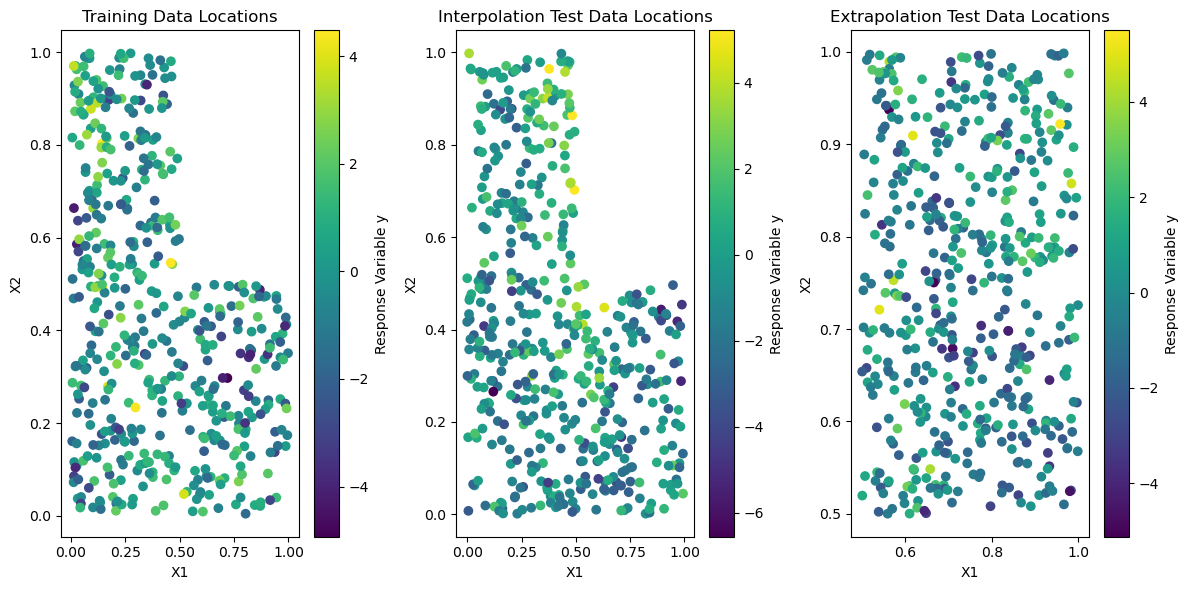

In [5]:
import matplotlib.pyplot as plt

# Extract locations and response variable y from the generated data
train_locations = train_spatial[4]
train_y = train_spatial[0]

interp_locations = test_interp_spatial[4]
interp_y = test_interp_spatial[0]

extrap_locations = test_extrap_spatial[4]
extrap_y = test_extrap_spatial[0]

# Plot the training data locations
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(train_locations[:, 0], train_locations[:, 1], c=train_y, cmap='viridis', marker='o')
plt.colorbar(label='Response Variable y')
plt.title('Training Data Locations')
plt.xlabel('X1')
plt.ylabel('X2')

# Plot the interpolation test data locations
plt.subplot(1, 3, 2)
plt.scatter(interp_locations[:, 0], interp_locations[:, 1], c=interp_y, cmap='viridis', marker='o')
plt.colorbar(label='Response Variable y')
plt.title('Interpolation Test Data Locations')
plt.xlabel('X1')
plt.ylabel('X2')

# Plot the extrapolation test data locations
plt.subplot(1, 3, 3)
plt.scatter(extrap_locations[:, 0], extrap_locations[:, 1], c=extrap_y, cmap='viridis', marker='o')
plt.colorbar(label='Response Variable y')
plt.title('Extrapolation Test Data Locations')
plt.xlabel('X1')
plt.ylabel('X2')

plt.tight_layout()
plt.show()

In [3]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal

# Set random seed for reproducibility
np.random.seed(42)

# Function to generate fixed effects F(x)
def generate_fixed_effects(n, d=9, C=None):
    """
    Generate fixed effects F(x) for n samples.
    
    Parameters:
        n (int): Number of samples.
        d (int): Number of predictor variables (default=9).
        C (float): Scaling constant to adjust variance of F(x) to 1.
    
    Returns:
        F (numpy.ndarray): Fixed effect values of shape (n,).
        X (numpy.ndarray): Predictor variables of shape (n, d).
    """
    X = np.random.normal(0, 1, size=(n, d))
    Fx = 2 * X[:, 0] + X[:, 1]**2 + 4 * (X[:, 2] > 0) + 2 * np.log(np.abs(X[:, 0] * X[:, 2]))
    
    if C is None:
        C = 1 / np.std(Fx)
    
    F = C * Fx
    return F, X

# Function to generate grouped random effects
def generate_grouped_random_effects(n, m, sigma1_squared=1):
    """
    Generate grouped random effects Zb.

    Parameters:
        n (int): Total number of samples.
        m (int): Number of groups.
        sigma1_squared (float): Variance of random effects.

    Returns:
        Zb (numpy.ndarray): Random effects of shape (n,).
        group_ids (numpy.ndarray): Group IDs for each sample.
    """
    group_ids = np.random.choice(m, size=n)  # Assign each sample to a group
    b = np.random.normal(0, np.sqrt(sigma1_squared), size=m)  # Random effects for each group
    Zb = b[group_ids]  # Assign random effects to each sample
    return Zb, group_ids

# Function to generate spatial Gaussian process random effects
def generate_spatial_gp(n, locations, sigma1_squared=1, rho=0.1):
    """
    Generate spatial Gaussian process random effects Zb.

    Parameters:
        n (int): Number of samples.
        locations (numpy.ndarray): Locations of shape (n, 2).
        sigma1_squared (float): Variance of the Gaussian process.
        rho (float): Range parameter for the exponential covariance function.

    Returns:
        Zb (numpy.ndarray): Spatial random effects of shape (n,).
    """
    # Exponential covariance function
    dists = cdist(locations, locations)
    covariance_matrix = sigma1_squared * np.exp(-dists / rho)
    
    # Simulate random effects from multivariate normal distribution
    Zb = multivariate_normal.rvs(mean=np.zeros(n), cov=covariance_matrix)
    return Zb

# Function to generate data based on the mixed effects model
def generate_data(n, model_type="grouped", m=500, sigma1_squared=1, sigma_squared=1, rho=0.1):
    """
    Generate data based on the mixed effects model.

    Parameters:
        n (int): Number of samples.
        model_type (str): Type of random effects model ("grouped" or "spatial").
        m (int): Number of groups (only for grouped random effects).
        sigma1_squared (float): Variance of random effects.
        sigma_squared (float): Variance of error term.
        rho (float): Range parameter for spatial GP (only for spatial model).

    Returns:
        y (numpy.ndarray): Response variable of shape (n,).
        X (numpy.ndarray): Predictor variables of shape (n, 9).
        Zb (numpy.ndarray): Random effects of shape (n,).
        epsilon (numpy.ndarray): Error term of shape (n,).
        group_ids or locations (numpy.ndarray): Group IDs or spatial locations.
    """
    # Generate fixed effects
    F, X = generate_fixed_effects(n)
    
    if model_type == "grouped":
        # Generate grouped random effects
        Zb, group_ids = generate_grouped_random_effects(n, m, sigma1_squared)
        locations_or_groups = group_ids
    elif model_type == "spatial":
        # Generate spatial locations
        locations = np.random.uniform(0, 1, size=(n, 2))
        # Generate spatial random effects
        Zb = generate_spatial_gp(n, locations, sigma1_squared, rho)
        locations_or_groups = locations
    else:
        raise ValueError("Invalid model_type. Choose from 'grouped' or 'spatial'.")
    
    # Generate error term
    epsilon = np.random.normal(0, np.sqrt(sigma_squared), size=n)
    
    # Combine to generate response variable y
    y = F + Zb + epsilon
    
    return y, X, Zb, epsilon, locations_or_groups

# Function to generate training and test datasets
def generate_train_test_data(n_train, n_test, model_type, m=500, sigma1_squared=1, sigma_squared=1, rho=0.1):
    """
    Generate training and test datasets (interpolation and extrapolation).

    Parameters:
        n_train (int): Number of training samples.
        n_test (int): Number of test samples.
        model_type (str): Type of random effects model ("grouped" or "spatial").
        m (int): Number of groups (only for grouped random effects).
        sigma1_squared (float): Variance of random effects.
        sigma_squared (float): Variance of error term.
        rho (float): Range parameter for spatial GP (only for spatial model).

    Returns:
        train_data (dict): Training data.
        test_data_interpolation (dict): Interpolation test data.
        test_data_extrapolation (dict): Extrapolation test data.
    """
    # Generate training data
    train_data = generate_data(n_train, model_type, m, sigma1_squared, sigma_squared, rho)
    
    # Generate test data for interpolation and extrapolation
    if model_type == "grouped":
        # Interpolation: Use the same groups as in training
        test_data_interpolation = generate_data(n_test, model_type, m, sigma1_squared, sigma_squared, rho)
        # Extrapolation: Generate new groups
        test_data_extrapolation = generate_data(n_test, model_type, m, sigma1_squared, sigma_squared, rho)
    elif model_type == "spatial":
        locations = np.random.uniform(0, 1, size=(n_test, 2))
        mask = (locations[:, 0] < 0.5) | (locations[:, 1] < 0.5)
        interpolation_locations = locations[mask]
        extrapolation_locations = locations[~mask]
        
        # Interpolation: Sample locations from [0, 1] x [0, 1] \ [0.5, 1] x [0.5, 1]
        Zb_interpolation = generate_spatial_gp(n_test, interpolation_locations, sigma1_squared, rho)
        F_interpolation, X_interpolation = generate_fixed_effects(n_test)
        epsilon_interpolation = np.random.normal(0, np.sqrt(sigma_squared), size=n_test)
        y_interpolation = F_interpolation + Zb_interpolation + epsilon_interpolation
        test_data_interpolation = {
            "y": y_interpolation,
            "X": X_interpolation,
            "Zb": Zb_interpolation,
            "epsilon": epsilon_interpolation,
            "locations": interpolation_locations,
        }
        
        # Extrapolation: Sample locations from [0.5, 1] x [0.5, 1]
        Zb_extrapolation = generate_spatial_gp(n_test, extrapolation_locations, sigma1_squared, rho)
        F_extrapolation, X_extrapolation = generate_fixed_effects(n_test)
        epsilon_extrapolation = np.random.normal(0, np.sqrt(sigma_squared), size=n_test)
        y_extrapolation = F_extrapolation + Zb_extrapolation + epsilon_extrapolation
        test_data_extrapolation = {
            "y": y_extrapolation,
            "X": X_extrapolation,
            "Zb": Zb_extrapolation,
            "epsilon": epsilon_extrapolation,
            "locations": extrapolation_locations,
        }
    else:
        raise ValueError("Invalid model_type. Choose from 'grouped' or 'spatial'.")
    
    return train_data, test_data_interpolation, test_data_extrapolation

# Example usage
n_train = 5000  # Training sample size
n_test = 500  # Test sample size

# Grouped random effects model
train_grouped, test_interp_grouped, test_extrap_grouped = generate_train_test_data(
    n_train, n_test, model_type="grouped", m=500, sigma1_squared=1, sigma_squared=1
)

# Spatial Gaussian process model
train_spatial, test_interp_spatial, test_extrap_spatial = generate_train_test_data(
    n_train, n_test, model_type="spatial", sigma1_squared=1, sigma_squared=1, rho=0.1
)


import matplotlib.pyplot as plt

# Function to visualize the data
def visualize_data(train_data, test_data_interpolation, test_data_extrapolation, model_type):
    y_train, X_train, Zb_train, epsilon_train, locations_or_groups_train = train_data
    y_test_interp, X_test_interp, Zb_test_interp, epsilon_test_interp, locations_or_groups_test_interp = test_data_interpolation
    y_test_extrap, X_test_extrap, Zb_test_extrap, epsilon_test_extrap, locations_or_groups_test_extrap = test_data_extrapolation
    
    if model_type == "grouped":
        # Visualize grouped random effects
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(Zb_train, bins=30, alpha=0.7, label='Train')
        plt.hist(Zb_test_interp, bins=30, alpha=0.7, label='Test Interpolation')
        plt.hist(Zb_test_extrap, bins=30, alpha=0.7, label='Test Extrapolation')
        plt.xlabel('Grouped Random Effects')
        plt.ylabel('Frequency')
        plt.legend()
        plt.title('Distribution of Grouped Random Effects')
        
        # Visualize response variable y
        plt.subplot(1, 2, 2)
        plt.hist(y_train, bins=30, alpha=0.7, label='Train')
        plt.hist(y_test_interp, bins=30, alpha=0.7, label='Test Interpolation')
        plt.hist(y_test_extrap, bins=30, alpha=0.7, label='Test Extrapolation')
        plt.xlabel('Response Variable y')
        plt.ylabel('Frequency')
        plt.legend()
        plt.title('Distribution of Response Variable y')
        
    elif model_type == "spatial":
        # Visualize spatial random effects
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(locations_or_groups_train[:, 0], locations_or_groups_train[:, 1], c=Zb_train, cmap='viridis', label='Train', alpha=0.7)
        plt.scatter(locations_or_groups_test_interp[:, 0], locations_or_groups_test_interp[:, 1], c=Zb_test_interp, cmap='plasma', label='Test', alpha=0.7)
        plt.colorbar(label='Spatial Random Effects')
        plt.xlabel('Location X1')
        plt.ylabel('Location X2')
        plt.legend()
        plt.title('Spatial Random Effects (Train & Test)')
        
        # Visualize response variable y
        plt.subplot(1, 2, 2)
        plt.scatter(locations_or_groups_train[:, 0], locations_or_groups_train[:, 1], c=y_train, cmap='viridis', label='Train', alpha=0.7)
        plt.scatter(locations_or_groups_test_interp[:, 0], locations_or_groups_test_interp[:, 1], c=y_test_interp, cmap='plasma', label='Test', alpha=0.7)
        plt.colorbar(label='Response Variable y')
        plt.xlabel('Location X1')
        plt.ylabel('Location X2')
        plt.legend()
        plt.title('Response Variable y (Train & Test)')
        
    else:
        raise ValueError("Invalid model_type. Choose from 'grouped' or 'spatial'.")
    
    # Show plots
    plt.tight_layout()
    plt.show()

# Visualize the grouped random effects model data
visualize_data(train_grouped, test_interp_grouped, test_extrap_grouped, model_type="grouped")

# Visualize the spatial Gaussian process model data
visualize_data(train_spatial, test_interp_spatial, test_extrap_spatial, model_type="spatial")


ValueError: Dimension mismatch: array 'cov' is of shape (364, 364), but 'mean' is a vector of length 500.

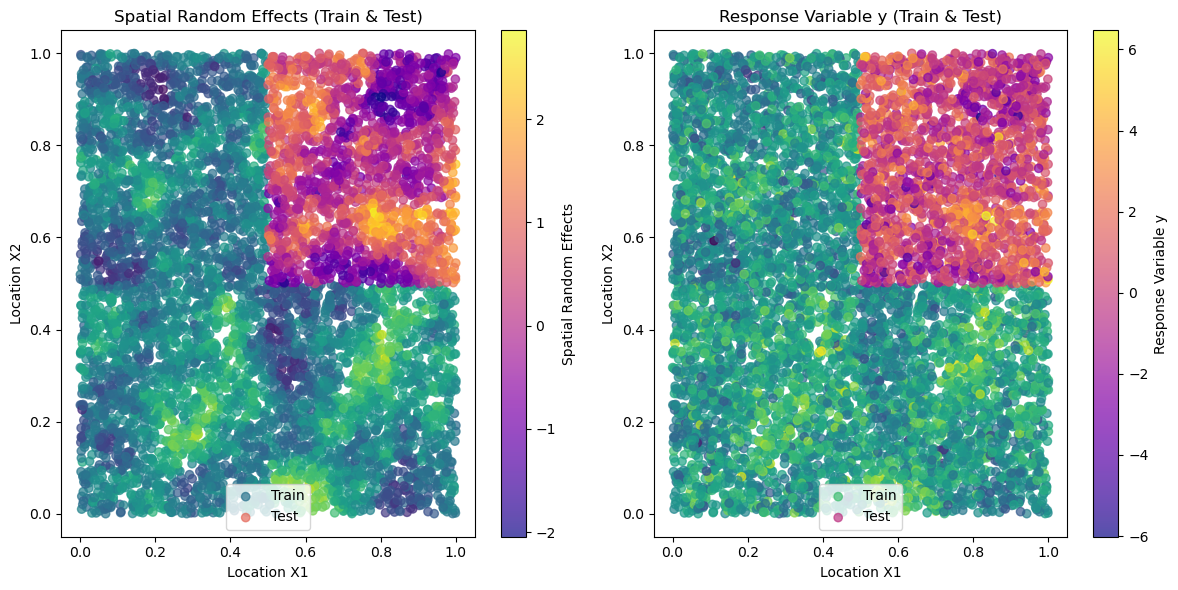

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal

# Set random seed for reproducibility
np.random.seed(42)

# Function to generate fixed effects F(x)
def generate_fixed_effects(n, d=9, C=None):
    X = np.random.normal(0, 1, size=(n, d))  # Generate X ~ N(0, I_d)
    # Define F(x) as given in the problem
    Fx = 2 * X[:, 0] + X[:, 1]**2 + 4 * (X[:, 2] > 0) + 2 * np.log(np.abs(X[:, 0] * X[:, 2]))
    
    if C is None:
        # Calculate C such that var(F(x)) = 1
        C = 1 / np.std(Fx)
    
    F = C * Fx
    return F, X

# Function to generate grouped random effects
def generate_grouped_random_effects(n, m, sigma1_squared=1):
    group_ids = np.random.choice(m, size=n)  # Assign each sample to a group
    b = np.random.normal(0, np.sqrt(sigma1_squared), size=m)  # Random effects for each group
    Zb = b[group_ids]  # Assign random effects to each sample
    return Zb, group_ids

# Function to generate spatial Gaussian process random effects
def generate_spatial_gp(n, locations, sigma1_squared=1, rho=0.1):
    # Exponential covariance function
    dists = cdist(locations, locations)
    covariance_matrix = sigma1_squared * np.exp(-dists / rho)
    
    # Simulate random effects from multivariate normal distribution
    Zb = multivariate_normal.rvs(mean=np.zeros(n), cov=covariance_matrix)
    return Zb

# Function to generate data based on the mixed effects model
def generate_data(n, model_type="grouped", m=500, sigma1_squared=1, sigma_squared=1, rho=0.1):
    # Generate fixed effects
    F, X = generate_fixed_effects(n)
    
    if model_type == "grouped":
        # Generate grouped random effects
        Zb, group_ids = generate_grouped_random_effects(n, m, sigma1_squared)
        locations_or_groups = group_ids
    elif model_type == "spatial":
        # Generate spatial locations
        locations = np.random.uniform(0, 1, size=(n, 2))
        mask = (locations[:, 0] < 0.5) | (locations[:, 1] < 0.5)
        locations_train = locations[mask]
        locations_test = locations[~mask]
        
        # Generate spatial random effects for training data
        Zb_train = generate_spatial_gp(len(locations_train), locations_train, sigma1_squared, rho)
        
        # Generate error term for training data
        epsilon_train = np.random.normal(0, np.sqrt(sigma_squared), size=len(locations_train))
        
        # Combine to generate response variable y for training data
        y_train = F[:len(locations_train)] + Zb_train + epsilon_train
        
        train_data = (y_train, X[:len(locations_train)], Zb_train, epsilon_train, locations_train)
        
        # Generate spatial random effects for test data
        Zb_test = generate_spatial_gp(len(locations_test), locations_test, sigma1_squared, rho)
        
        # Generate error term for test data
        epsilon_test = np.random.normal(0, np.sqrt(sigma_squared), size=len(locations_test))
        
        # Combine to generate response variable y for test data
        y_test = F[len(locations_train):] + Zb_test + epsilon_test
        
        test_data = (y_test, X[len(locations_train):], Zb_test, epsilon_test, locations_test)
        
        return train_data, test_data
    
    else:
        raise ValueError("Invalid model_type. Choose from 'grouped' or 'spatial'.")
    
# Function to visualize the data in the same graph
def visualize_data(train_data, test_data):
    y_train, X_train, Zb_train, epsilon_train, locations_or_groups_train = train_data
    y_test, X_test, Zb_test, epsilon_test, locations_or_groups_test = test_data
    
    plt.figure(figsize=(12, 6))
    
    # Visualize spatial random effects for training and test data in the same graph
    plt.subplot(1, 2, 1)
    plt.scatter(locations_or_groups_train[:, 0], locations_or_groups_train[:, 1], c=Zb_train,
                cmap='viridis', label='Train', alpha=0.7)
    plt.scatter(locations_or_groups_test[:, 0], locations_or_groups_test[:, 1], c=Zb_test,
                cmap='plasma', label='Test', alpha=0.7)
    plt.colorbar(label='Spatial Random Effects')
    plt.xlabel('Location X1')
    plt.ylabel('Location X2')
    plt.legend()
    plt.title('Spatial Random Effects (Train & Test)')
    
    # Visualize response variable y for training and test data in the same graph
    plt.subplot(1, 2, 2)
    plt.scatter(locations_or_groups_train[:, 0], locations_or_groups_train[:, 1], c=y_train,
                cmap='viridis', label='Train', alpha=0.7)
    plt.scatter(locations_or_groups_test[:, 0], locations_or_groups_test[:, 1], c=y_test,
                cmap='plasma', label='Test', alpha=0.7)
    plt.colorbar(label='Response Variable y')
    plt.xlabel('Location X1')
    plt.ylabel('Location X2')
    plt.legend()
    plt.title('Response Variable y (Train & Test)')
    
    # Show plots
    plt.tight_layout()
    plt.show()

n_train = 5000  # Training sample size

# Generate training and test data for spatial Gaussian process model with specified regions
train_spatial_data,test_spatial_data = generate_data(n=n_train//2*3,
                                                      model_type="spatial",
                                                      sigma1_squared=1,
                                                      sigma_squared=1,
                                                      rho=0.1)

# Visualize the spatial Gaussian process model data with specified regions in the same graph
visualize_data(train_spatial_data,test_spatial_data)

In [6]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import GPy

# Set random seed for reproducibility
np.random.seed(42)

# Function to generate fixed effects F(x)
def generate_fixed_effects(n, d=9, C=None):
    X = np.random.normal(0, 1, size=(n, d))  # Generate X ~ N(0, I_d)
    # Define F(x) as given in the problem
    Fx = 2 * X[:, 0] + X[:, 1]**2 + 4 * (X[:, 2] > 0) + 2 * np.log(np.abs(X[:, 0] * X[:, 2]))
    
    if C is None:
        # Calculate C such that var(F(x)) = 1
        C = 1 / np.std(Fx)
    
    F = C * Fx
    return F, X

# Function to generate grouped random effects
def generate_grouped_random_effects(n, m, sigma1_squared=1):
    group_ids = np.random.choice(m, size=n)  # Assign each sample to a group
    b = np.random.normal(0, np.sqrt(sigma1_squared), size=m)  # Random effects for each group
    Zb = b[group_ids]  # Assign random effects to each sample
    return Zb, group_ids

# Function to generate spatial Gaussian process random effects
def generate_spatial_gp(n, locations, sigma1_squared=1, rho=0.1):
    # Exponential covariance function
    dists = cdist(locations, locations)
    covariance_matrix = sigma1_squared * np.exp(-dists / rho)
    
    # Simulate random effects from multivariate normal distribution
    Zb = multivariate_normal.rvs(mean=np.zeros(n), cov=covariance_matrix)
    return Zb

# Function to generate data based on the mixed effects model
def generate_data(n, model_type="grouped", m=500, sigma1_squared=1, sigma_squared=1, rho=0.1):
    # Generate fixed effects
    F, X = generate_fixed_effects(n)
    
    if model_type == "grouped":
        # Generate grouped random effects
        Zb, group_ids = generate_grouped_random_effects(n, m, sigma1_squared)
        locations_or_groups = group_ids
    elif model_type == "spatial":
        # Generate spatial locations
        locations = np.random.uniform(0, 1, size=(n, 2))
        mask = (locations[:, 0] < 0.5) | (locations[:, 1] < 0.5)
        locations_train = locations[mask]
        locations_test = locations[~mask]
        
        # Generate spatial random effects for training data
        Zb_train = generate_spatial_gp(len(locations_train), locations_train, sigma1_squared, rho)
        
        # Generate error term for training data
        epsilon_train = np.random.normal(0, np.sqrt(sigma_squared), size=len(locations_train))
        
        # Combine to generate response variable y for training data
        y_train = F[:len(locations_train)] + Zb_train + epsilon_train
        
        train_data = (y_train, X[:len(locations_train)], Zb_train, epsilon_train, locations_train)
        
        # Generate spatial random effects for test data
        Zb_test = generate_spatial_gp(len(locations_test), locations_test, sigma1_squared, rho)
        
        # Generate error term for test data
        epsilon_test = np.random.normal(0, np.sqrt(sigma_squared), size=len(locations_test))
        
        # Combine to generate response variable y for test data
        y_test = F[len(locations_train):] + Zb_test + epsilon_test
        
        test_data = (y_test, X[len(locations_train):], Zb_test, epsilon_test, locations_test)
        
        return train_data, test_data
    
    else:
        raise ValueError("Invalid model_type. Choose from 'grouped' or 'spatial'.")

class GPBoost:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, input_dim=9, kernel=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.input_dim = input_dim
        self.kernel = kernel if kernel else GPy.kern.RBF(input_dim=self.input_dim)
        self.trees = []
        self.gp = None

    def fit(self, X, y):
        residuals = y.copy()
        for _ in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            self.trees.append(tree)
            residuals -= self.learning_rate * tree.predict(X)
        
        self.gp = GPy.models.GPRegression(X, residuals.reshape(-1, 1), self.kernel)
        self.gp.optimize()

    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for tree in self.trees:
            pred += self.learning_rate * tree.predict(X)
        
        gp_pred, _ = self.gp.predict(X)
        return pred + gp_pred.flatten()

# Example usage with your generated data
n_train = 5000  # Training sample size
train_spatial_data, test_spatial_data = generate_data(n=n_train//2*3, model_type="spatial", sigma1_squared=1, sigma_squared=1, rho=0.1)

y_train, X_train, Zb_train, epsilon_train, locations_train = train_spatial_data
y_test, X_test, Zb_test, epsilon_test, locations_test = test_spatial_data

model = GPBoost(n_estimators=50, learning_rate=0.1, max_depth=3, input_dim=X_train.shape[1])
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Plotting the results
plt.scatter(locations_test[:, 0], y_test, color='blue', label='True values')
plt.scatter(locations_test[:, 0], predictions, color='red', label='Predictions')
plt.legend()
plt.show()

KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 